In [91]:
import os
import sys
import gzip
import code
import urllib
import importlib
import tensorflow.python.platform
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm
from PIL import Image

In [92]:
COLAB = False
BRANCH = 'ben-crap'

In [93]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/Shareddrives/ML_Road_Segmentation/CS-433-project-2/project_road_segmentation'
    os.chdir(drive_path)
    from helpers.colab import mount_and_pull
    BRANCH_NAME = BRANCH
    mount_and_pull(BRANCH_NAME, drive, os)

In [94]:
%load_ext autoreload
%autoreload 2

from helpers.image_processing import *
from helpers.file_manipulation import *
from helpers.constants import *
from helpers.prediction_checking import *
from helpers.machine_learning import *
from helpers.loss_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
RESTORE_MODEL = False  # If True, restore existing model instead of training a new one
SAVE_MODEL = False
GENERATE_PREDICTION = False  # If True, will generate a CSV to submit on AICrowd

MODEL_NAME = 'cnn_ben'  # For now, cnn, unet-1, unet-2
SAVE_DIR = MODELS_SAVE_DIR + MODEL_NAME + '/'

NUM_EPOCHS = 250

In [122]:
mod = importlib.import_module('models.' + MODEL_NAME)
model_function = getattr(mod, MODEL_NAME)
model = model_function()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 400, 400, 16)      448       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 50, 50, 64)       

In [104]:
X_train, X_test, y_train, y_test = get_train_test(data_augmentation=True)

Loading data/generated/shift/groundtruth/: 100%|████████████████████████████████████| 100/100 [00:00<00:00, 298.51it/s]


Training features shape :  (500, 400, 400, 3)
Training labels shape :  (500, 400, 400)


In [105]:
def extract_blocks(a, blocksize, keep_as_view=False):
    M,N = a.shape
    b0 = blocksize
    b1 = blocksize
    if keep_as_view==0:
        return a.reshape(M//b0,b0,N//b1,b1).swapaxes(1,2).reshape(-1,b0,b1)
    else:
        return a.reshape(M//b0,b0,N//b1,b1).swapaxes(1,2)
    
patches = []
for i in range(len(y_train)):
    patches.append(extract_blocks(y_train[i], PATCH_SIZE))
patches_array = np.array(patches)
print(patches_array.shape)

(400, 625, 16, 16)


In [106]:
patches_labeled = []
for index_i,i in enumerate(patches_array):
    patches_labeled.append([])
    for index_j, j in enumerate(i):
        patches_labeled[index_i].append(predict_patch(j))
label_array = np.array(patches_labeled)
print(label_array)

[[0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [1 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [107]:
y_train_patched = label_array.reshape(400,25,25)

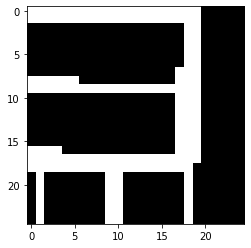

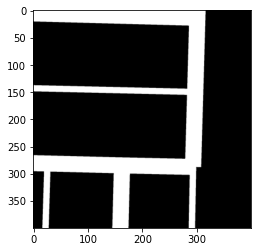

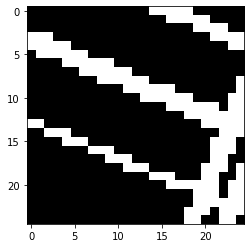

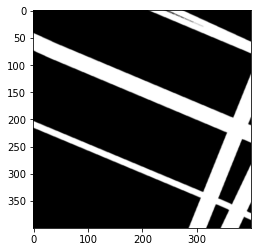

In [108]:
IMG_TO_CHECK = 2
for i in np.random.randint(len(label_array), size=IMG_TO_CHECK):
    plt.figure()
    plt.imshow(y_train_patched[i], cmap='gray', vmin=0, vmax=1)
    plt.figure()
    plt.imshow(y_train[i], cmap='gray', vmin=0, vmax=1)

In [ ]:
# TODO : Try to train unet-2 with 250 epoch and focal tversky loss and check for overfit
# Hyperparameters to tweak : Alpha and Gamma from focal tversky loss for accuracy, and dropout rate for overfit
metrics=[tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall(),
        ]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5)
            ]
if RESTORE_MODEL:
    model = tf.keras.models.load_model(SAVE_DIR, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
else:  
    model = model_function()
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    with tf.device('/cpu:0'):
        history = model.fit(X_train, y_train_patched, 
                            epochs = NUM_EPOCHS,
                            validation_split=VALIDATION_SIZE,
                            callbacks=None)
    
#model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics='accuracy')

Train on 320 samples, validate on 80 samples
Epoch 1/250
320/320 [==============================] - 33s 103ms/sample - loss: 0.8869 - accuracy: 0.6831 - val_loss: 0.6197 - val_accuracy: 0.7382
Epoch 2/250
320/320 [==============================] - 34s 105ms/sample - loss: 0.5905 - accuracy: 0.7389 - val_loss: 0.6020 - val_accuracy: 0.7262
Epoch 3/250
320/320 [==============================] - 31s 98ms/sample - loss: 0.5788 - accuracy: 0.7432 - val_loss: 0.5883 - val_accuracy: 0.7382
Epoch 4/250
320/320 [==============================] - 32s 101ms/sample - loss: 0.5656 - accuracy: 0.7445 - val_loss: 0.5728 - val_accuracy: 0.7306
Epoch 5/250
 64/320 [=====>........................] - ETA: 32s - loss: 0.5511 - accuracy: 0.7411

In [9]:
if SAVE_MODEL:
    model.save(SAVE_DIR)

In [10]:
with tf.device('/cpu:0'):
    train_predictions = model.predict(X_train).squeeze()
    test_predictions = model.predict(X_test).squeeze()

Minimum and maximum prediction :  0.5259763 0.47147062
Road ratio :  0.4970501


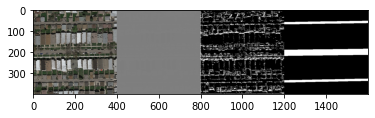

In [58]:
visualize_random_predictions(X_train, y_train, train_predictions, size=10)

In [ ]:
visualize_random_predictions(X_test, y_test, test_predictions, size=10)

In [ ]:
if COLAB:
    from helpers.colab import download_model
    from google.colab import files
    download_model(MODEL_NAME, SAVE_DIR, files)